In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F  # Import functional module
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [9]:
X_train = pd.read_csv('/home/niiquaye/ECE457B/data/FashionMNISTwithaTwistW25/x_train.csv') # every row is an image vector
y_train = pd.read_csv('/home/niiquaye/ECE457B/data/FashionMNISTwithaTwistW25/y_train.csv')
X_test = pd.read_csv('/home/niiquaye/ECE457B/data/FashionMNISTwithaTwistW25/x_test.csv')
y_test = pd.read_csv('/home/niiquaye/ECE457B/data/FashionMNISTwithaTwistW25/y_test.csv')


In [10]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(CNNClassifier, self).__init__()
        
        # Convolutional Layer 1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # 3x3 filter
        
        # Convolutional Layer 2
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)  # 3x3 filter
        
        # Max Pooling
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Fully Connected Layer
        self.fc1 = nn.Linear(32 * 196, 512)  # Adjusted for the flattened size after pooling
        
        # Output Layer (Softmax will be applied outside the model during loss computation)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))  # First convolutional layer
        x = self.pool(x)  # Max pooling
        x = self.relu(self.conv2(x))  # Second convolutional layer
        x = self.pool(x)  # Max pooling again
        
        x = x.view(-1, 32 * 196)  # Flatten the output for the fully connected layer

        x = self.relu(self.fc1(x))  # Fully connected layer 1

        feature_vector = x

        x = self.fc2(x)  # Output layer
        
        return feature_vector, x

In [11]:
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32).unsqueeze(1)  # Convert X_train to tensor
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long).squeeze()  # Convert y_train to tensor (for classification tasks)

# Create a TensorDataset
train_data = TensorDataset(X_train_tensor, y_train_tensor)

# Create DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)


In [12]:
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32).unsqueeze(1)  # Convert X_test to tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long).squeeze()  # Convert y_test to tensor (for classification tasks)

# Create a TensorDataset
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [13]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [14]:
# Model, optimizer, loss function
model = CNNClassifier(num_classes=5).to(device)  # Move model to GPU
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [46]:
num_epochs = 1000

In [47]:
print(torch.min(y_train_tensor), torch.max(y_train_tensor))


tensor(0) tensor(4)


In [ ]:
def train_model(model, optimizer, criterion, num_epochs):
    training_losses = []
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for inputs, labels in train_loader:
            # Move input and labels to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            _, outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        training_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

    return model, training_losses, num_epochs 

In [15]:
def train_model(model, optimizer, criterion, num_epochs, device):
    training_losses = []
    training_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            # Move input and labels to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            _, outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)  # Get class with highest probability
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Compute average loss and accuracy
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total * 100  # Convert to percentage

        training_losses.append(epoch_loss)
        training_accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    return model, training_losses, training_accuracies, num_epochs



In [37]:
# After training, plot the accuracy graph
def plot_metrics(losses, accuracies, num_epochs, model_name):
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(10, 5))

    plt.suptitle(f"{model_name} - Training Metrics Over Epochs", fontsize=14, fontweight="bold")

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses,  linestyle='-', label="Training Loss", color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Running Loss")
    plt.title("Training Running Loss Over Epochs")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies,  linestyle='-', label="Training Accuracy", color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy Over Epochs")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [50]:
def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            feature_vectors, _ = model(inputs)  # Extract feature vectors
            features.append(feature_vectors.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    features = np.vstack(features)
    labels_list = np.hstack(labels_list)

    scaler = StandardScaler()
    features = scaler.fit_transform(features) 
    
    return features, labels_list

In [18]:
model, training_losses, training_accuracies, epochs = train_model(model, optimizer, criterion, num_epochs=100, device=device)


Epoch 1/100, Loss: 0.2602, Accuracy: 96.36%
Epoch 2/100, Loss: 0.0699, Accuracy: 97.76%
Epoch 3/100, Loss: 0.0629, Accuracy: 98.11%
Epoch 4/100, Loss: 0.0521, Accuracy: 98.45%
Epoch 5/100, Loss: 0.0414, Accuracy: 98.74%
Epoch 6/100, Loss: 0.0365, Accuracy: 98.92%
Epoch 7/100, Loss: 0.0325, Accuracy: 99.07%
Epoch 8/100, Loss: 0.0301, Accuracy: 99.18%
Epoch 9/100, Loss: 0.0288, Accuracy: 99.18%
Epoch 10/100, Loss: 0.0184, Accuracy: 99.53%
Epoch 11/100, Loss: 0.0177, Accuracy: 99.49%
Epoch 12/100, Loss: 0.0144, Accuracy: 99.60%
Epoch 13/100, Loss: 0.0173, Accuracy: 99.58%
Epoch 14/100, Loss: 0.0130, Accuracy: 99.68%
Epoch 15/100, Loss: 0.0143, Accuracy: 99.67%
Epoch 16/100, Loss: 0.0138, Accuracy: 99.67%
Epoch 17/100, Loss: 0.0099, Accuracy: 99.80%
Epoch 18/100, Loss: 0.0139, Accuracy: 99.70%
Epoch 19/100, Loss: 0.0085, Accuracy: 99.83%
Epoch 20/100, Loss: 0.0087, Accuracy: 99.82%
Epoch 21/100, Loss: 0.0138, Accuracy: 99.75%
Epoch 22/100, Loss: 0.0087, Accuracy: 99.83%
Epoch 23/100, Loss:

In [51]:
model_features, model_labels = extract_features(model, test_loader, device)

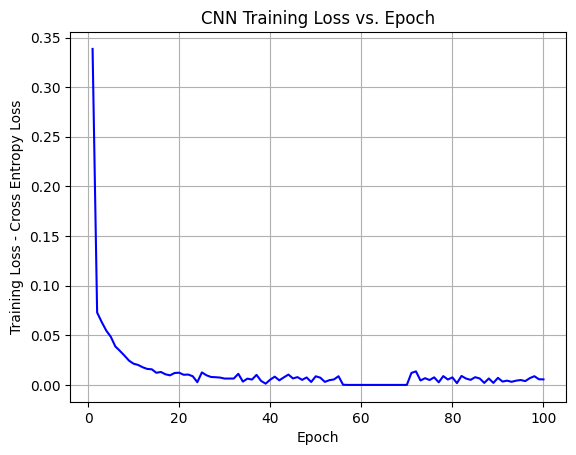

In [54]:
plt.plot(range(1, epochs+1), training_losses, linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Training Loss - Cross Entropy Loss")
plt.title("CNN Training Loss vs. Epoch")
plt.grid()
plt.show()

In [28]:
# After training, you can test your model
def eval_model(model, device):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation during testing
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            _, outputs = model(inputs)

            probabilities = F.softmax(outputs, dim=1) # apply softmax 

            _, predicted = torch.max(probabilities, 1)

            total += labels.size(0)

            correct += (predicted == labels).sum().item()

        print(f"ACCURACY: {100 * correct / total}%")

In [29]:
eval_model(model, device)

ACCURACY: 98.46%


In [30]:
class VGG16(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        # flatten 'x' here before passing into first layer
        # Reshape (10000, 1, 784) -> (10000, 1, 28, 28)
        x = x.view(-1, 1, 28, 28) 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)

        
        return_features =  out 
    
        out = self.fc2(out)
        return return_features, out

In [31]:
# Model, optimizer, loss function
vgg16_model = VGG16(num_classes=5).to(device)  # Move model to GPU
optimizer = optim.Adam(vgg16_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [32]:
vgg16_model, training_losses_vgg, training_accuracies_vgg, epochs = train_model(vgg16_model, optimizer, criterion, 100, device=device)

Epoch 1/100, Loss: 0.2418, Accuracy: 92.43%
Epoch 2/100, Loss: 0.1243, Accuracy: 96.86%
Epoch 3/100, Loss: 0.0936, Accuracy: 97.56%
Epoch 4/100, Loss: 0.0752, Accuracy: 98.02%
Epoch 5/100, Loss: 0.0710, Accuracy: 98.22%
Epoch 6/100, Loss: 0.0637, Accuracy: 98.44%
Epoch 7/100, Loss: 0.0528, Accuracy: 98.61%
Epoch 8/100, Loss: 0.0494, Accuracy: 98.74%
Epoch 9/100, Loss: 0.0419, Accuracy: 98.87%
Epoch 10/100, Loss: 0.0442, Accuracy: 98.90%
Epoch 11/100, Loss: 0.0325, Accuracy: 99.11%
Epoch 12/100, Loss: 0.0287, Accuracy: 99.16%
Epoch 13/100, Loss: 0.0375, Accuracy: 99.06%
Epoch 14/100, Loss: 0.0277, Accuracy: 99.24%
Epoch 15/100, Loss: 0.0316, Accuracy: 99.18%
Epoch 16/100, Loss: 0.0257, Accuracy: 99.35%
Epoch 17/100, Loss: 0.0392, Accuracy: 99.17%
Epoch 18/100, Loss: 0.0174, Accuracy: 99.48%
Epoch 19/100, Loss: 0.0217, Accuracy: 99.45%
Epoch 20/100, Loss: 0.0191, Accuracy: 99.47%
Epoch 21/100, Loss: 0.0232, Accuracy: 99.40%
Epoch 22/100, Loss: 0.0281, Accuracy: 99.43%
Epoch 23/100, Loss:

- [vgg16 CNN model](https://medium.com/@ilaslanduzgun/create-vgg-from-scratch-in-pytorch-aa194c269b55) 
- [research paper link](https://arxiv.org/abs/1409.1556)
- [pdf link](https://arxiv.org/pdf/1409.1556)

In [33]:
eval_model(vgg16_model, device)

ACCURACY: 98.82%


In [53]:
model_features_vgg, model_labels_vgg = extract_features(vgg16_model, test_loader, device)

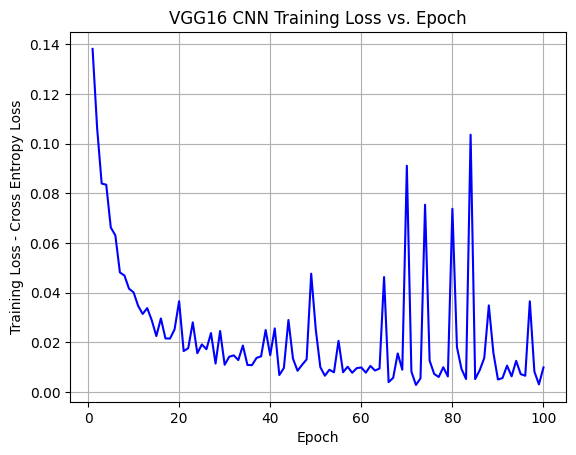

In [95]:
plt.plot(range(1, epochs+1), training_losses_vgg, linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Training Loss - Cross Entropy Loss")
plt.title("VGG16 CNN Training Loss vs. Epoch")
plt.grid()
plt.show()

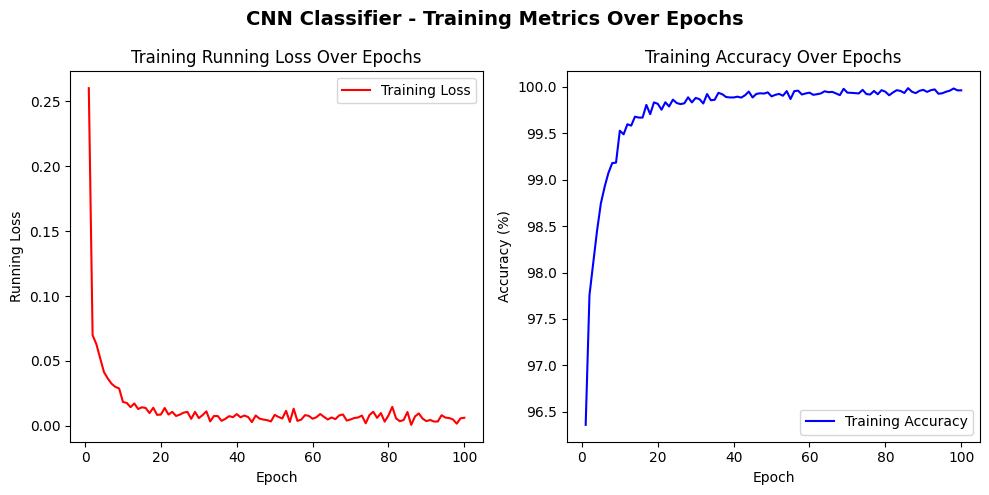

In [38]:
plot_metrics(training_losses, training_accuracies, epochs, 'CNN Classifier')

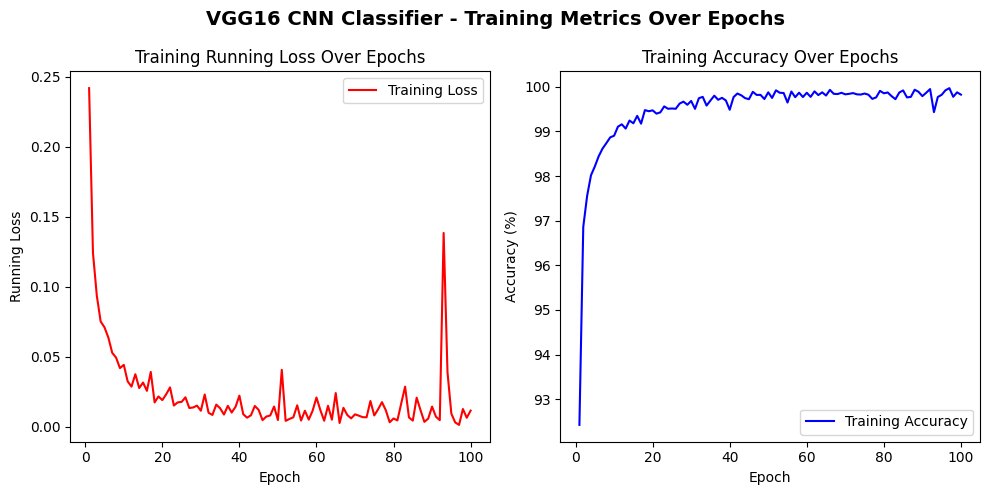

In [39]:
plot_metrics(training_losses_vgg, training_accuracies_vgg, epochs, 'VGG16 CNN Classifier')

In [59]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns


def plot_pca(X_data, y_data, predictor_attribute, data_set_name):
    # Perform PCA to reduce data to 2 components
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_data)

    # Create a DataFrame to hold the PCA results
    pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])

    # Optionally, add the target variable to the DataFrame for coloring
    pca_df[predictor_attribute] = y_data

    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue=predictor_attribute, data=pca_df, palette='viridis', s=100, edgecolor='k')
    plt.title(f'PCA Visualization of {data_set_name}', fontsize=16)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title=predictor_attribute, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    return pca_df

def plot_t_sne(X_data, y_data, predictor_attribute, data_set_name, perplexity=30):
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    X_tsne = tsne.fit_transform(X_data)

    # Create a DataFrame to hold the t-SNE results
    tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])

    # Optionally, add the target variable to the DataFrame for coloring
    tsne_df[predictor_attribute] = y_data

    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='TSNE1', y='TSNE2', hue=predictor_attribute, data=tsne_df, palette='viridis', s=100, edgecolor='k')
    plt.title(f't-SNE Visualization of {data_set_name}', fontsize=16)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title=predictor_attribute, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

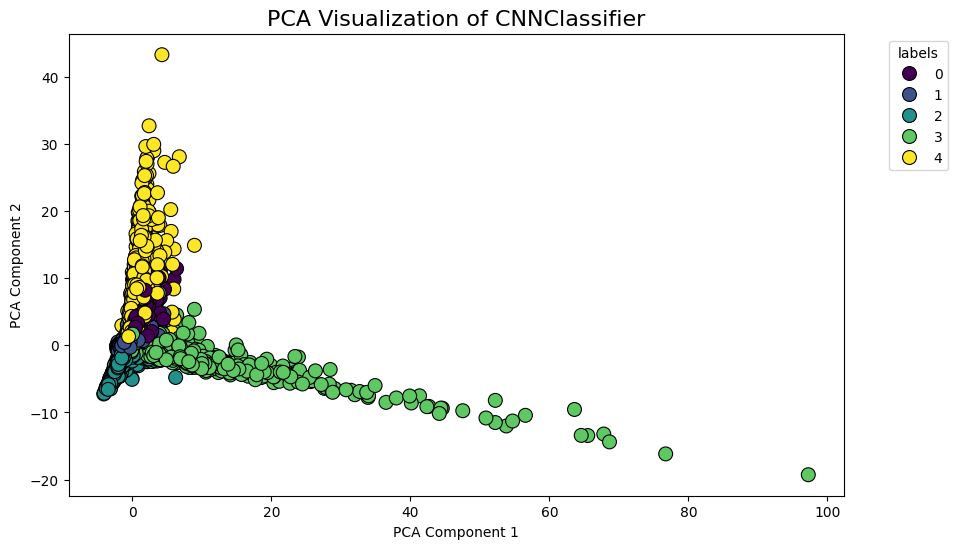

In [73]:
pca = plot_pca(model_features, model_labels, 'labels', 'CNNClassifier')

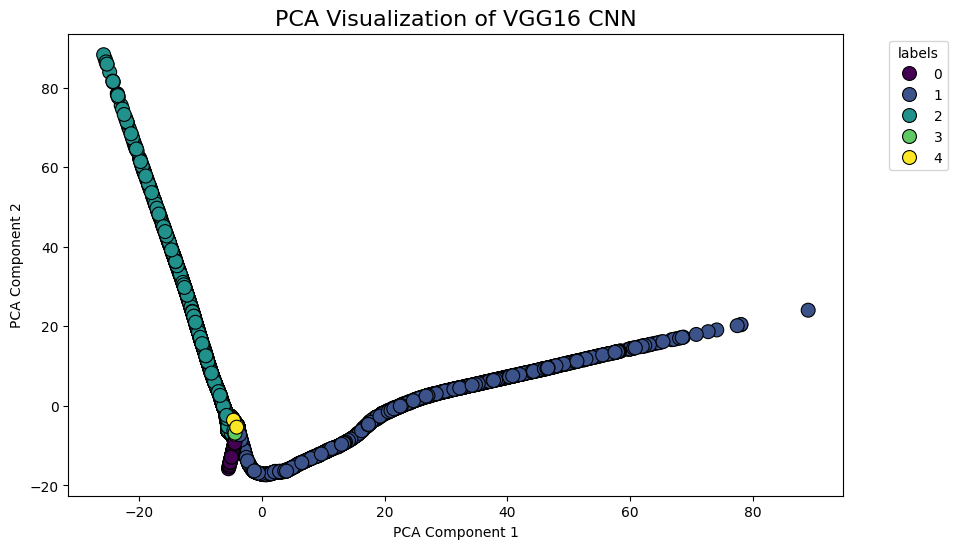

In [76]:
pca_vgg = plot_pca(model_features_vgg, model_labels_vgg, 'labels', 'VGG16 CNN')

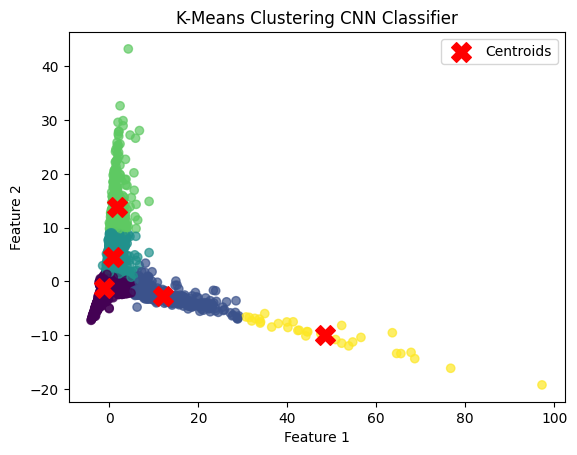

In [74]:
k = 5  # Number of clusters/classes
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
pca = pca.drop(columns=['labels'])
labels = kmeans.fit_predict(pca)  


plt.scatter(pca.iloc[:, 0], pca.iloc[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label="Centroids")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("K-Means Clustering CNN Classifier")
plt.legend()
plt.show()

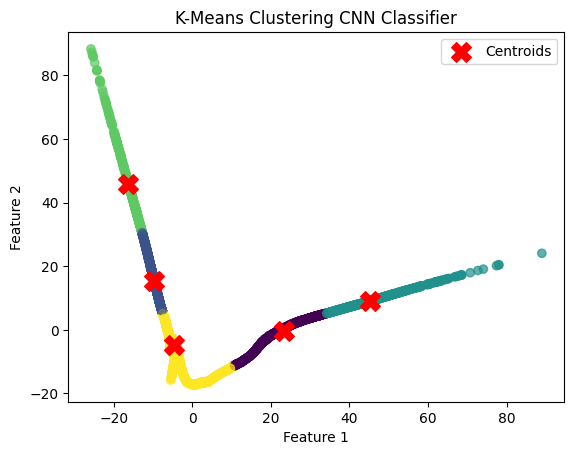

In [77]:
k = 5  # Number of clusters/classes
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
pca_vgg = pca_vgg.drop(columns=['labels'])
labels = kmeans.fit_predict(pca_vgg)  


plt.scatter(pca_vgg.iloc[:, 0], pca_vgg.iloc[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label="Centroids")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("K-Means Clustering CNN Classifier")
plt.legend()
plt.show()

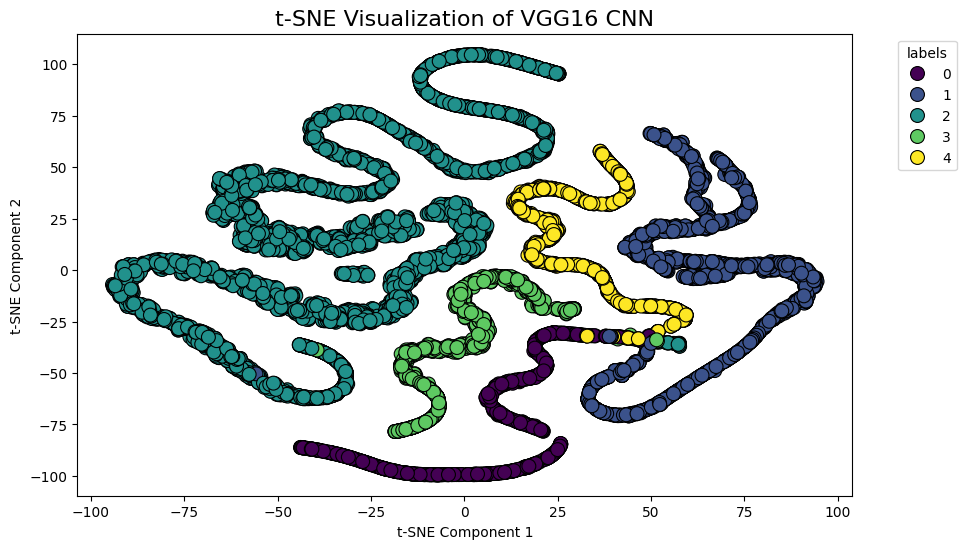

In [78]:
plot_t_sne(model_features_vgg, model_labels_vgg, 'labels', 'VGG16 CNN')

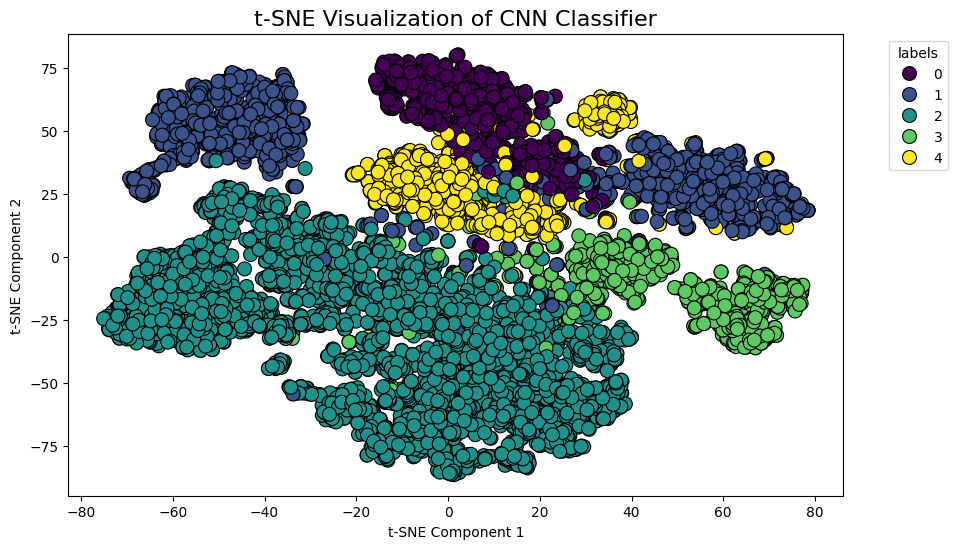

In [79]:
plot_t_sne(model_features, model_labels, 'labels', 'CNN Classifier')